In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from model import TimeTransformer
from data_preprocessing import load_data
import matplotlib.pyplot as plt

In [34]:
# Hyperparameters
INPUT_DIM = 7  # Number of features
EMBED_DIM = 64
NHEAD = 4
NUM_LAYERS = 3
OUTPUT_DIM = 1  # Predict pickup count
SEQ_LEN = 24  # Predict using last 24 timesteps
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 50
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", DEVICE)

Using cpu


In [35]:
# File paths
TRAIN_FILE = "/scratch/gl2758/PTSA/output/final_outputs_will/MSG_2h_train.csv"
TEST_FILE = "/scratch/gl2758/PTSA/output/final_outputs_will/MSG_2h_test.csv"

# Load data
train_loader, test_loader, scaler = load_data(TRAIN_FILE, TEST_FILE, seq_len=SEQ_LEN, batch_size=BATCH_SIZE)

# Initialize the model
model = TimeTransformer(INPUT_DIM, EMBED_DIM, NHEAD, NUM_LAYERS, OUTPUT_DIM, SEQ_LEN).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch.unsqueeze(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {train_loss:.4f}")

/ext3/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Loss: 115404.5859
Epoch 2/50, Loss: 113281.8439
Epoch 3/50, Loss: 110716.1981
Epoch 4/50, Loss: 107585.4754
Epoch 5/50, Loss: 103947.4682
Epoch 6/50, Loss: 99881.4321
Epoch 7/50, Loss: 95491.3253
Epoch 8/50, Loss: 90838.0281
Epoch 9/50, Loss: 86001.7308
Epoch 10/50, Loss: 81057.1263
Epoch 11/50, Loss: 76049.9810
Epoch 12/50, Loss: 71115.6055
Epoch 13/50, Loss: 66242.3996
Epoch 14/50, Loss: 61540.7421
Epoch 15/50, Loss: 57060.7798
Epoch 16/50, Loss: 52862.7731
Epoch 17/50, Loss: 48952.0873
Epoch 18/50, Loss: 45394.6596
Epoch 19/50, Loss: 42210.1059
Epoch 20/50, Loss: 39362.0899
Epoch 21/50, Loss: 36914.6811
Epoch 22/50, Loss: 34814.1602
Epoch 23/50, Loss: 33045.9222
Epoch 24/50, Loss: 31581.6517
Epoch 25/50, Loss: 30424.2533
Epoch 26/50, Loss: 29477.1449
Epoch 27/50, Loss: 28756.7549
Epoch 28/50, Loss: 28203.8438
Epoch 29/50, Loss: 27795.6663
Epoch 30/50, Loss: 27493.3864
Epoch 31/50, Loss: 27281.2023
Epoch 32/50, Loss: 27122.2869
Epoch 33/50, Loss: 27041.1320
Epoch 34/50, L

In [36]:
from sklearn.metrics import mean_absolute_percentage_error

# Evaluate model
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        predictions = model(X_batch).cpu().numpy()
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predictions)

# Metrics
y_true, y_pred = np.array(y_true), np.array(y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)


print(f"Test RMSE: {rmse:.4f}, R^2 Score: {r2:.4f}, MAPE: {mape:.4f}")

Test RMSE: 124.4467, R^2 Score: 0.4141, MAPE: 1.2153


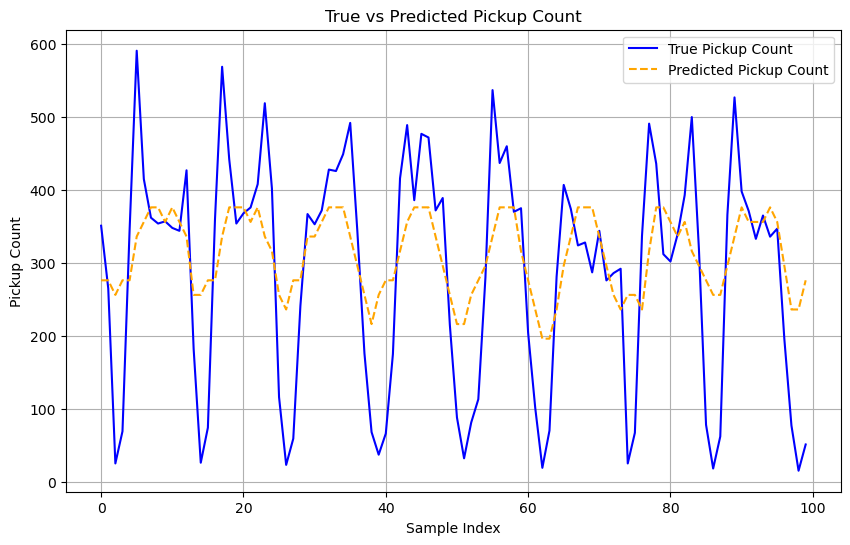

In [37]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(y_true[:100], label="True Pickup Count", color="blue")
plt.plot(y_pred[:100], label="Predicted Pickup Count", color="orange", linestyle="--")
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("True vs Predicted Pickup Count")
plt.legend()
plt.grid()
plt.show()